<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



Кликкер для колаба, чтобы он не отваливался

In [ ]:
import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
display(IPython.display.Javascript(js_code))

В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torchsummary import summary
from IPython.display import clear_output
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import plotly.express as px

%matplotlib inline
sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"kirillvoronin","key":"4f6bf529026f8b45142312dd3e3a959b"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tommykamaz/faces-dataset-small

faces-dataset-small.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!mkdir images
!unzip -q -o faces-dataset-small.zip -d images | awk 'BEGIN {ORS=" "} {if(NR%50==0)print "."}'

mkdir: cannot create directory ‘images’: File exists


In [ ]:
def get_dataloader(image_size, batch_size):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """
    # TODO: resize images, convert them to tensors and build dataloader
    transform = tt.Compose([
        tt.Resize(image_size),
        tt.CenterCrop(image_size),
        tt.ToTensor(),
        tt.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
    datasets = ImageFolder(DATA_DIR, transform=transform)
    loader = DataLoader(datasets, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    return loader

In [ ]:
image_size = 64

#TODO: build dataloader and transfer it to device
DATA_DIR = './images/'
batch_size = 64
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
train_loader = get_dataloader(image_size, batch_size)

In [ ]:
def show_samples(loader, amt=64):
    plt.figure(figsize=(8,8))
    plt.axis("off")
    batch, _ = next(iter(loader))
    plt.imshow(make_grid(batch.detach()[:amt], nrow=8, padding=2, normalize=True).permute(1, 2, 0))

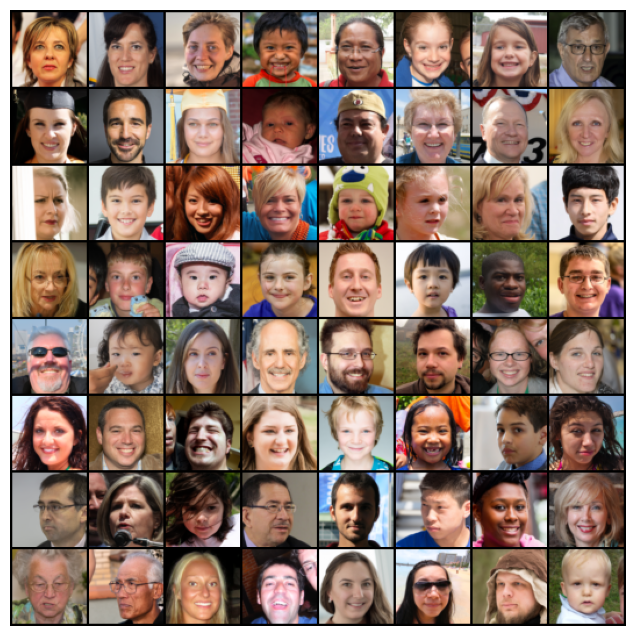

In [ ]:
show_samples(train_loader)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)   
        nn.init.constant_(m.bias.data, 0.0)

In [ ]:
discriminator = nn.Sequential(

    nn.Conv2d(3, image_size, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(image_size, 2*image_size, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(2*image_size),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(2*image_size, 4*image_size, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(4*image_size),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(4*image_size, 8*image_size, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(8*image_size),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(8*image_size, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid()
    )

In [ ]:
latent_size = 256 # choose latent size

generator = nn.Sequential(

    nn.ConvTranspose2d(latent_size, 8*image_size, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(8*image_size),
    nn.LeakyReLU(0.2, inplace=True),

    nn.ConvTranspose2d(8*image_size, 4*image_size, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(4*image_size),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.ConvTranspose2d(4*image_size, 2*image_size, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(2*image_size),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.ConvTranspose2d(2*image_size, image_size, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.ConvTranspose2d(image_size, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    )

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
lr = 0.0005

model = {
    "discriminator": discriminator,
    "generator": generator
}

model['generator'].apply(weights_init)
model['discriminator'].apply(weights_init)

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

optim = {
        'discriminator': torch.optim.AdamW(model['discriminator'].parameters(), lr=lr, betas=(0.5, 0.999)),
        'generator': torch.optim.AdamW(model['generator'].parameters(), lr=lr, betas=(0.5, 0.999))
    }

In [ ]:
def fit(model, criterion, optimizer, epochs, lr, start_idx=1):
    # TODO: build optimizers and train your GAN
    model["discriminator"].to(device)
    model["generator"].to(device)
    model['discriminator'].train()
    model['generator'].train()
    losses_g,losses_d,real_scores,fake_scores = [],[],[],[]
    torch.cuda.empty_cache()
 
    for epoch in range(epochs):
        loss_g,loss_d,real_score,fake_score = [],[],[],[]
        
        for real_images, _ in tqdm(train_loader):
            real_images = real_images.to(device)
            optimizer['discriminator'].zero_grad()

            # Pass real images through discriminator
            real_preds = model['discriminator'](real_images)
            real_targets = torch.FloatTensor(real_images.size(0), 1).uniform_(0.95, 1.0).to(device)
            real_loss = criterion['discriminator'](real_preds, real_targets)
            real_score.append(torch.mean(real_preds).item())
            
            # Generate fake images
            latent = torch.randn(real_images.size(0), latent_size, 1, 1, device=device)
            fake_images = model['generator'](latent)

            # Pass fake images through discriminator
            fake_targets = torch.FloatTensor(real_images.size(0), 1).uniform_(0.0, 0.05).to(device)
            fake_preds = model['discriminator'](fake_images)
            fake_loss = criterion['discriminator'](fake_preds, fake_targets)
            fake_score.append(torch.mean(fake_preds).item())

            # Update discriminator weights
            loss_discriminator = real_loss + fake_loss
            loss_discriminator.backward()
            optimizer['discriminator'].step()
            loss_d.append(loss_discriminator.item())

            # Train generator
            # Clear generator gradients
            optimizer['generator'].zero_grad()
            
            # Generate fake images
            latent = torch.randn(real_images.size(0), latent_size, 1, 1, device=device)
            fake_images = model['generator'](latent)
            
            # Try to fool the discriminator
            preds = model['discriminator'](fake_images)
            targets = torch.FloatTensor(real_images.size(0), 1).uniform_(0.95, 1.0).to(device)
            loss_generator = criterion['generator'](preds, targets)
            
            # Update generator weights
            loss_generator.backward()
            optimizer['generator'].step()
            loss_g.append(loss_generator.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g))
        losses_d.append(np.mean(loss_d))
        real_scores.append(np.mean(real_score))
        fake_scores.append(np.mean(fake_score))
    
        plt.figure(figsize=(12,12))
        clear_output(wait=True)
        plt.axis("off")
        plt.title(f'epoch: {epoch+1}, loss_d: {round(losses_g[-1], 2)}, loss_g:{round(losses_d[-1], 2)}, real_score: {round(real_scores[-1], 2)}, fake_score: {round(fake_scores[-1], 2)}')
        plt.imshow(np.transpose(make_grid(fake_images.to(device)[:16], padding=2, normalize=True).cpu(),(1,2,0)))
        plt.show()

    return losses_g, losses_d, real_scores, fake_scores

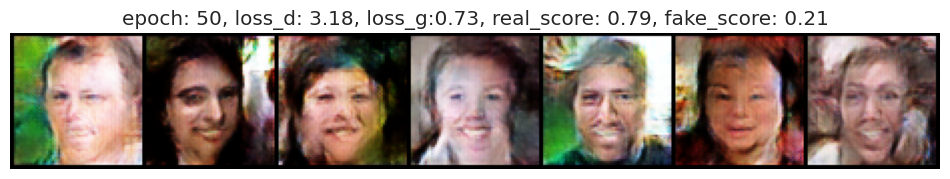

In [ ]:
losses_g, losses_d, real_scores, fake_scores = fit(model, criterion, optim, epochs=50, lr=lr)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [ ]:
def show_result(losses_g, losses_d, real_scores, fake_scores):
    plt.figure(figsize=(10, 18))

    plt.subplot(2, 1, 1)
    plt.plot(losses_d, '-')
    plt.plot(losses_g, '-')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss_generator', 'loss_discriminator'])
    plt.title('Loss-scores GAN')

    plt.subplot(2, 1, 2)
    plt.plot(real_scores, '-')
    plt.plot(fake_scores, '-')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.legend(['scores_generator', 'scores_discriminator'])
    plt.title('Scores GAN')

    plt.show()

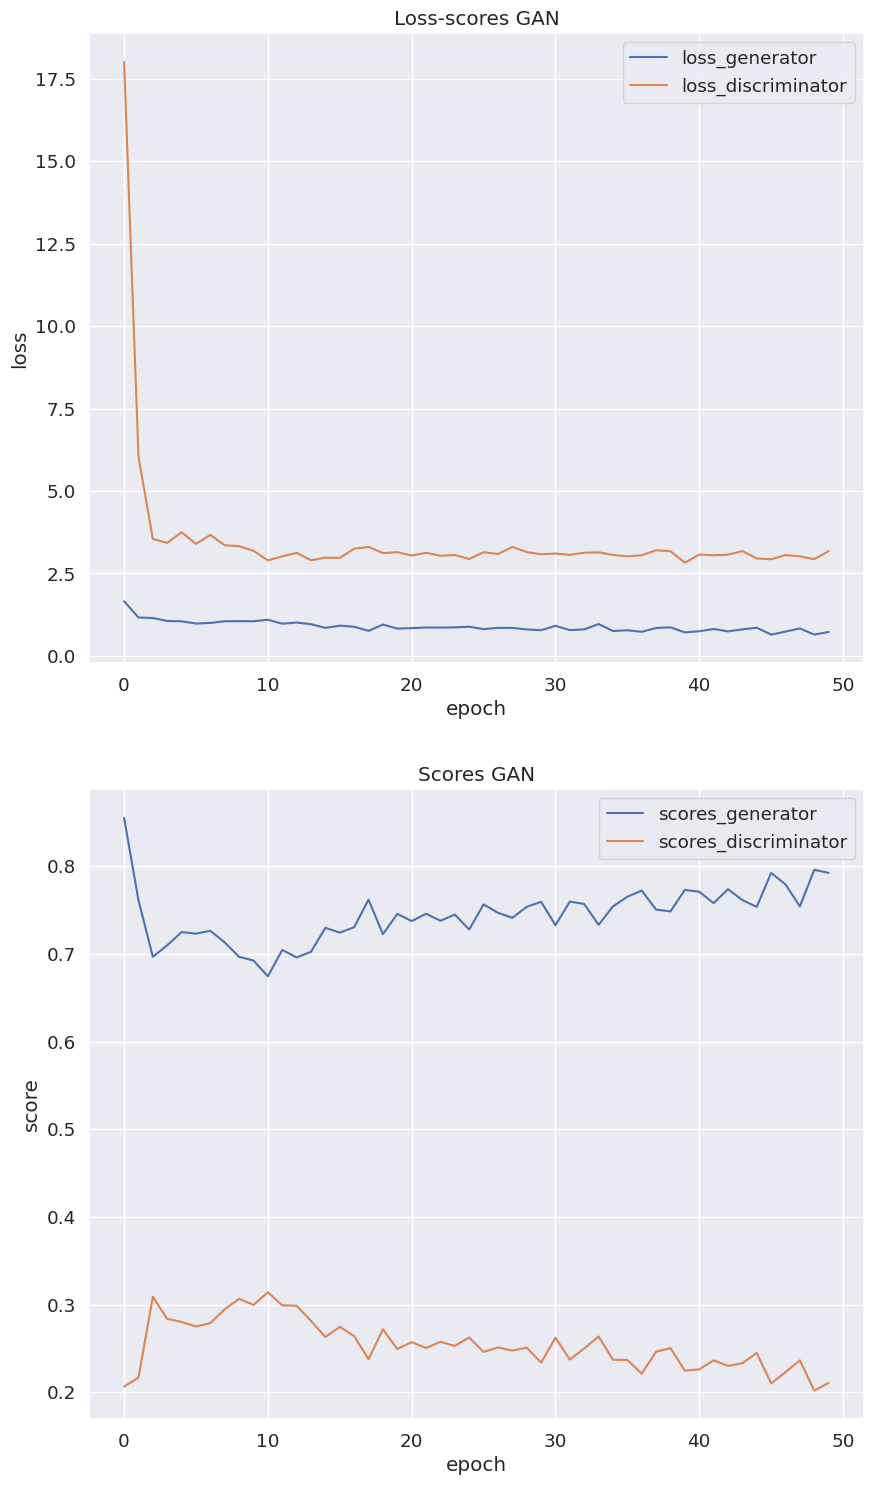

In [ ]:
show_result(losses_g, losses_d, real_scores, fake_scores)

Графики, хоть и являются достаточно шумными, но явно демострируют что обучение генератора и дискриминатора проходит. В целом, графики потожи на демострируемые в учебных материалах. Качество обучения можно было бы повысить, используя больший датасет, большее разрешение изображения или более длительное обучение. В данном случае ограничением при примененнии подобных улучшений стало использование Коллаба в качестве среды для обучения.

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
n_images = 16

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent).cpu().detach()

In [ ]:
def show_images(generated):
  # TODO: show generated images
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.axis("off")
    plt.imshow(np.transpose(make_grid(generated.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

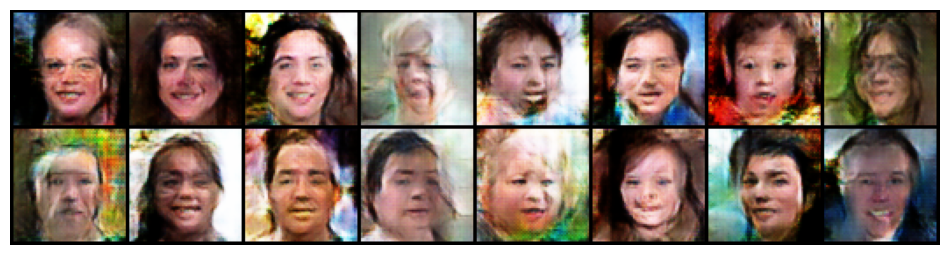

In [ ]:
show_images(fake_images)

Как вам качество получившихся изображений?

На изображениях присутствуют только общие черты человеческих лиц, в части случаев присутствует достаточно ровный овал лица. Однако лица далеки от идеала - много случаев с невыраженными формами и чертами лица, а также слишком абстрактные фоны. Ограничения и возможности, описанные выше, и в данной заметке.

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
n_images = 3143
fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device) 
fake_images = model['generator'](fixed_latent).cpu().detach()
real_images = next(iter(get_dataloader(64, n_images)))[0].cpu().detach()

In [ ]:
features = torch.cat((fake_images, real_images), 0).numpy().reshape(-1,3*64*64)
labels = torch.cat((torch.zeros(n_images,1), torch.ones(n_images,1))).numpy()

In [ ]:
model = KNeighborsClassifier(n_neighbors=1)
loo = LeaveOneOut()

In [ ]:
labels_list, predictions_list = [],[]
for i, (train_index, test_index) in enumerate(loo.split(features)):
    features_train, features_test = features[train_index], features[test_index]
    labels_train, labels_test = labels[train_index], labels[test_index]
    model.fit(features_train, labels_train.reshape(-1))
    predictions = model.predict(features_test)
    
    labels_list.append(labels_test.reshape(-1)[0])
    predictions_list.append(predictions[0])
    
print(classification_report(labels_list, predictions_list))

              precision    recall  f1-score   support

         0.0       0.75      0.76      0.76      3143
         1.0       0.76      0.74      0.75      3143

    accuracy                           0.75      6286
   macro avg       0.75      0.75      0.75      6286
weighted avg       0.75      0.75      0.75      6286



<Axes: >

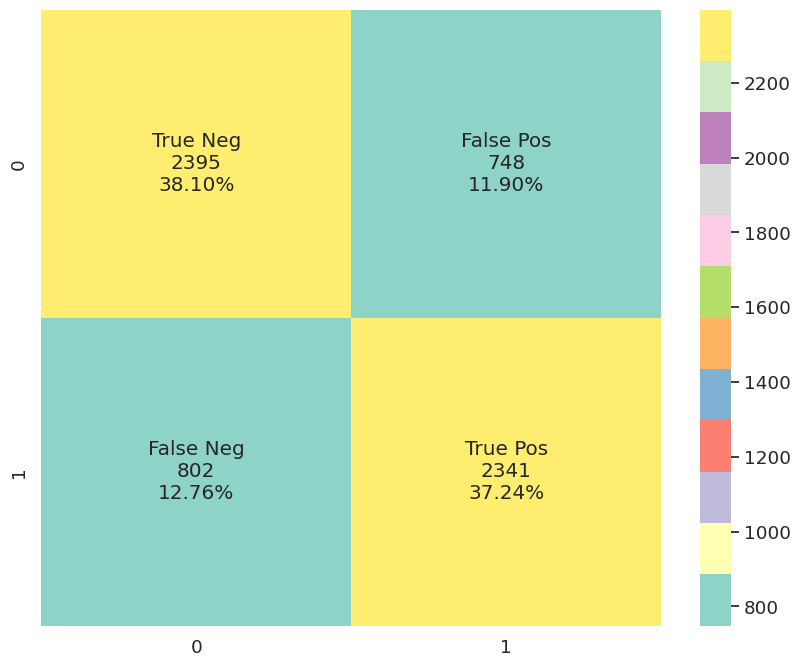

In [ ]:
plt.figure(figsize=(10, 8))

cf_matrix = confusion_matrix(np.array(labels_list), np.array(predictions_list))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
lbls = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
lbls = np.asarray(lbls).reshape(2,2)
sns.heatmap(cf_matrix, annot=lbls, fmt='', cmap='Set3')

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Из матрицы видно, что наибольшее количество случаев - TP и TN, то есть дескриминатор чаще правильно отличает изображения, а генератор не доучен. Оптимальным accuracy было бы близкое к 0.5, демонстриующее, что наблюдается баланс между обеими системами.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
labels = labels.reshape(-1, 1)
emb = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(features)

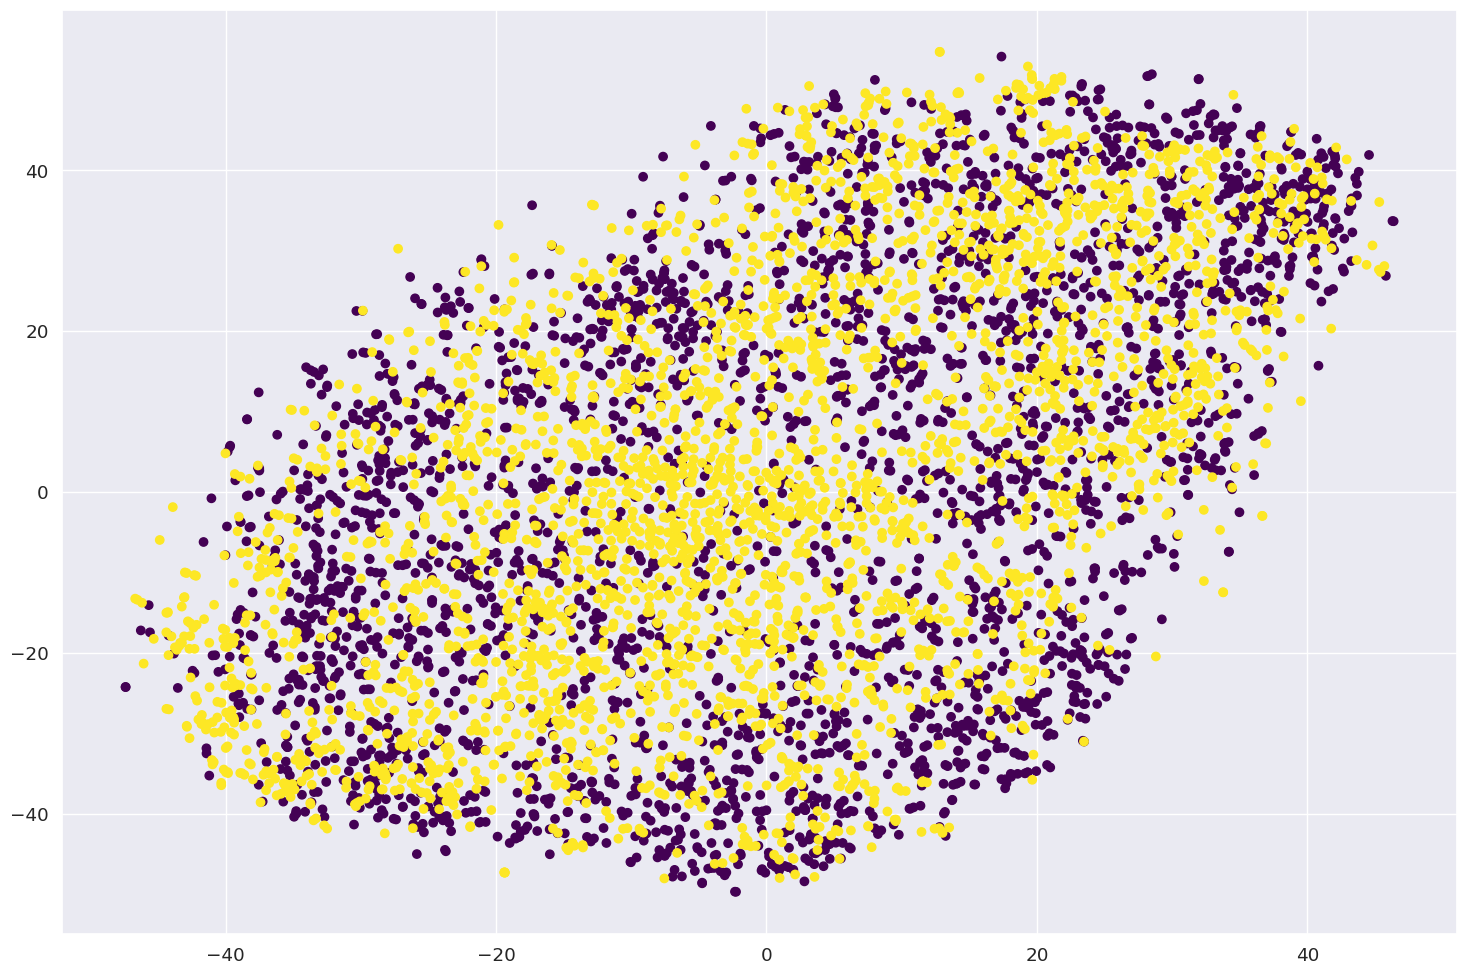

In [ ]:
plt.figure(figsize=(18, 12))
plt.scatter(emb[:, 0], emb[:, 1], c=labels, cmap='viridis')

Прокомментируйте получившийся результат:

Классетры ближко расположенны друг к дргугу и не достаточно хорошо разделимы, хотя все же стоит заметить, что в центральной области преобладает один тип тичек - настоящих изображений, а ближе к границе - другой - ложных изображений.